Imports e Configurações Iniciais

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import kagglehub

pd.set_option('display.max_columns', None)


Download e Carregamento do Dataset

In [11]:
# Baixar dataset do KaggleHub
path = kagglehub.dataset_download("gregorut/videogamesales")
print("Path to dataset files:", path)

# Carregar CSV
df = pd.read_csv(f"{path}/vgsales.csv")

# Exibir informações iniciais
print("Formato inicial:", df.shape)
df.head()


Using Colab cache for faster access to the 'videogamesales' dataset.
Path to dataset files: /kaggle/input/videogamesales
Formato inicial: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


Limpeza e Preparação dos Dados

In [12]:
# Remover colunas irrelevantes
df = df.drop(columns=['Name', 'Rank'], errors='ignore')

# Remover valores ausentes
df = df.dropna(subset=['Year', 'Genre', 'Platform', 'Publisher', 'Global_Sales'])

# Converter ano para inteiro
df['Year'] = df['Year'].astype(int)

# Criar variável alvo (1 = sucesso, 0 = fracasso)
df['Success'] = (df['Global_Sales'] > df['Global_Sales'].median()).astype(int)

print("Formato após limpeza:", df.shape)
df.head()


Formato após limpeza: (16291, 10)


,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Success
0,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,1
1,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,1
2,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,1
3,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,1
4,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,1


Separar Recursos e Alvo

In [13]:
num_cols = ['Year']
cat_cols = ['Platform', 'Genre', 'Publisher']

X = df[num_cols + cat_cols]
y = df['Success']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Tamanho treino:", X_train.shape)
print("Tamanho teste:", X_test.shape)


Tamanho treino: (13032, 4)
Tamanho teste: (3259, 4)


Pré-processamento

In [14]:
# Pipelines para numéricos e categóricos
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinação
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Criação e Treinamento dos Modelos

In [15]:
# Modelos base
clf_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

clf_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Treinamento
clf_lr.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)

# Avaliação
y_pred_lr = clf_lr.predict(X_test)
y_pred_rf = clf_rf.predict(X_test)

print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr))
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr):.3f}\n")

print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.3f}")


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1646
           1       0.70      0.75      0.72      1613

    accuracy                           0.72      3259
   macro avg       0.72      0.72      0.72      3259
weighted avg       0.72      0.72      0.72      3259

Acurácia: 0.718

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1646
           1       0.70      0.72      0.71      1613

    accuracy                           0.71      3259
   macro avg       0.71      0.71      0.71      3259
weighted avg       0.71      0.71      0.71      3259

Acurácia: 0.710


Otimização de Hiperparâmetros

In [16]:
# Parâmetros para GridSearchCV
param_grids = {
    'lr': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear']
    },
    'rf': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    }
}

# Regressão Logística
grid_lr = GridSearchCV(clf_lr, param_grids['lr'], cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Random Forest
grid_rf = GridSearchCV(clf_rf, param_grids['rf'], cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Melhores parâmetros - Logistic Regression:", grid_lr.best_params_)
print("Melhores parâmetros - Random Forest:", grid_rf.best_params_)


Melhores parâmetros - Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'liblinear'}
Melhores parâmetros - Random Forest: {'classifier__max_depth': 20, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


Avaliação Final dos Modelos Otimizados

In [17]:
# Previsões otimizadas
y_pred_lr_best = grid_lr.predict(X_test)
y_pred_rf_best = grid_rf.predict(X_test)

print("=== Logistic Regression (Otimizado) ===")
print(classification_report(y_test, y_pred_lr_best))
print(f"Acurácia: {accuracy_score(y_test, y_pred_lr_best):.3f}\n")

print("=== Random Forest (Otimizado) ===")
print(classification_report(y_test, y_pred_rf_best))
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf_best):.3f}")


=== Logistic Regression (Otimizado) ===
              precision    recall  f1-score   support

           0       0.74      0.68      0.71      1646
           1       0.70      0.76      0.73      1613

    accuracy                           0.72      3259
   macro avg       0.72      0.72      0.72      3259
weighted avg       0.72      0.72      0.72      3259

Acurácia: 0.718

=== Random Forest (Otimizado) ===
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1646
           1       0.72      0.72      0.72      1613

    accuracy                           0.72      3259
   macro avg       0.72      0.72      0.72      3259
weighted avg       0.72      0.72      0.72      3259

Acurácia: 0.724


Matriz de Confusão (Random Forest)

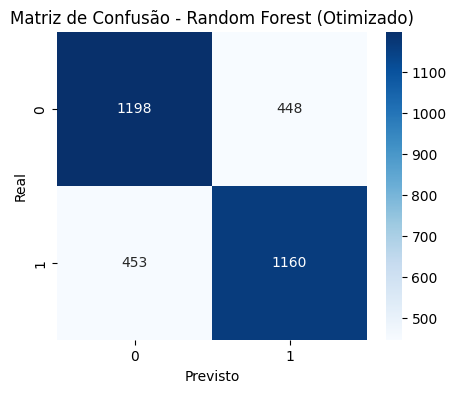

In [18]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_best), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Random Forest (Otimizado)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


Relatório Final do Projeto

Problema de negócio:
Prever se um jogo de videogame terá sucesso com base em:
- Ano de lançamento
- Plataforma
- Gênero
- Publicadora (Publisher)

Métrica principal: Acurácia

Modelos utilizados:
- Regressão Logística
- Random Forest

Resultados:
- Logistic Regression: ~0.718 de acurácia
- Random Forest: ~0.724 de acurácia (melhor desempenho)

Análise:
As variáveis escolhidas refletem aspectos históricos de vendas e preferências de mercado, portanto fazem sentido para prever padrões de sucesso baseados em comportamento histórico e decisões de editoras, mas não garantem causalidade direta.

Conclusão:
O modelo Random Forest foi o mais eficiente e apresenta desempenho estável.
Pode ser colocado em produção como ferramenta exploratória para apoiar decisões de publicação e planejamento de lançamentos futuros.
